In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

import sys
import numpy as np
import seaborn as sns
sys.path.append('..')
sys.path.append('../stylegan3')

from stylegan_generator import StyleGANGenerator

In [2]:
data_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
labels_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_1/resnet34_eyeglasses.pkl'

import pickle, h5py

labels = None
with open(labels_path,'rb') as f:
    labels = np.round(pickle.load(f))

data = None
with h5py.File(data_path, 'r') as f:
    data = f['z'][:]

zero_indices = np.where(labels == 0)[0]
zero_indices = np.random.choice(zero_indices, 22547, replace=False)

one_indices = np.where(labels == 1)[0]
indices = np.concatenate((one_indices, zero_indices))

labels = labels[indices]
data = data[indices]

dataset = TensorDataset(torch.Tensor(data),torch.Tensor(labels))
train_data, valid_data, test_data = random_split(dataset, [0.8, 0.1, 0.1])

<Axes: ylabel='Count'>

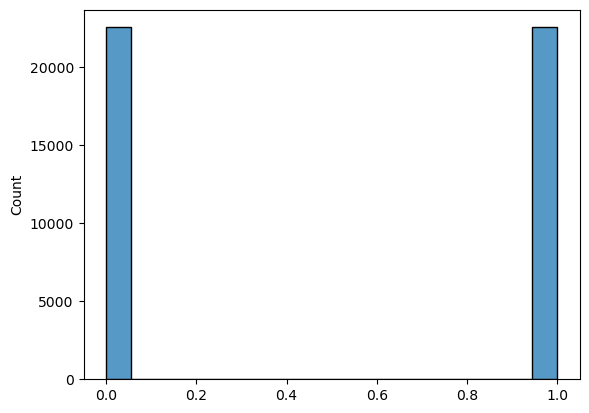

In [3]:
sns.histplot(labels)

In [4]:
class LatentEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64))
        
        self.decoder = nn.Sequential(
            nn.Linear(65, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Tanh())            
        
    def forward(self, x, y):
        latent = self.encoder(x)
        x = self.decoder(torch.cat((y.reshape((y.shape[0],-1)), latent),1))
        return x,latent

In [5]:
batch_size = 16
num_epochs = 100
learning_rate = 1e-4
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = LatentEncoder()
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

save_filename = 'latent_encoder_full_mse.pt'

loss = {}

loss['train'] = []
loss['valid'] = []
loss['test'] = []
best_valid_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
               
        output,latent = model(x, y)
        train_loss = criterion(output, x)
       
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss['train'].append(train_loss.data.item())
    
    model.eval()
    with torch.no_grad():
        for data in valid_dataloader:
            x, y = data
            x = x.cuda()
            y = y.cuda()
            
            output,latent = model(x, y)            
            val_loss = criterion(output, x)
            
    loss['valid'].append(val_loss.data.item())
    
    if loss['valid'][-1] < best_valid_loss:
        torch.save(model.state_dict(), save_filename)
        best_valid_loss = loss['valid'][-1]
   
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss["train"][-1]}, valid_loss:{loss["valid"][-1]}')
    

model.load_state_dict(torch.load(save_filename))

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        
        output,latent = model(x, y)
        test_loss = criterion(output, x)
        
        loss['test'].append(test_loss.data.item())

print(f'test_loss:{np.mean(np.array(loss["test"]))}')

epoch [1/100], loss:0.9362267255783081, valid_loss:0.9299848079681396
epoch [2/100], loss:0.9310123920440674, valid_loss:0.9098128080368042
epoch [3/100], loss:0.8927768468856812, valid_loss:0.9038987755775452
epoch [4/100], loss:0.8741702437400818, valid_loss:0.8958578705787659
epoch [5/100], loss:0.8637722730636597, valid_loss:0.9115591645240784
epoch [6/100], loss:0.8631061315536499, valid_loss:0.8922903537750244
epoch [7/100], loss:0.893110454082489, valid_loss:0.9061999320983887
epoch [8/100], loss:0.8960136771202087, valid_loss:0.9018102884292603
epoch [9/100], loss:0.866651713848114, valid_loss:0.8956255316734314
epoch [10/100], loss:0.8730966448783875, valid_loss:0.8611406683921814
epoch [11/100], loss:0.8709720373153687, valid_loss:0.8864690661430359
epoch [12/100], loss:0.853003203868866, valid_loss:0.8872511982917786
epoch [13/100], loss:0.8519691228866577, valid_loss:0.860537052154541
epoch [14/100], loss:0.8649153709411621, valid_loss:0.8902989625930786
epoch [15/100], los

In [6]:
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
generator = StyleGANGenerator(network_pkl)

In [8]:
test = torch.Tensor(np.random.randn(1,64))
test_zero = torch.cat((torch.zeros((1,1)),test),1)
test_one = torch.cat((torch.ones((1,1)),test),1)

print(test_zero, test_one)

model.eval()
with torch.no_grad():
    pred_zero = model.decoder(test_zero.cuda())
    pred_one = model.decoder(test_one.cuda())
    
generator.generate_from('pred_zero.png', pred_zero.cpu().numpy().reshape(-1,512))
generator.generate_from('pred_one.png', pred_one.cpu().numpy().reshape(-1,512))

tensor([[ 0.0000,  0.3604, -0.7846,  1.1637,  0.8550, -2.9459, -0.6882, -0.0216,
         -0.9294, -0.7217,  0.6160,  1.4988,  0.4372, -0.0732,  1.4922, -0.4713,
         -1.1141, -1.0219, -0.0608,  1.1892,  1.5896,  3.0025,  0.1249, -0.0785,
         -0.7194,  1.5885, -0.4166, -1.8800,  0.9411,  0.0656,  0.2047, -0.3238,
          0.1768,  0.2095,  0.7477, -0.1713,  1.1147,  0.4381, -1.1719,  1.6152,
          1.9346,  0.1443, -0.8288, -0.9735,  0.7283, -0.7377,  2.1416, -1.5849,
          0.0196,  2.3692,  0.6935,  0.8185,  2.6239, -0.4838,  0.0451, -0.2680,
          0.4489,  0.5783, -0.6385,  0.4992, -0.9286,  0.8538, -0.0686,  0.2974,
          0.9746]]) tensor([[ 1.0000,  0.3604, -0.7846,  1.1637,  0.8550, -2.9459, -0.6882, -0.0216,
         -0.9294, -0.7217,  0.6160,  1.4988,  0.4372, -0.0732,  1.4922, -0.4713,
         -1.1141, -1.0219, -0.0608,  1.1892,  1.5896,  3.0025,  0.1249, -0.0785,
         -0.7194,  1.5885, -0.4166, -1.8800,  0.9411,  0.0656,  0.2047, -0.3238,
        